In [2]:
import pandas as pd
import numpy as np, os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load Data

In [3]:
folder_path = u'C:/Users/cricr/PycharmProjects/AI-project/features/128' 

# List all files in the folder
file_names = [file for file in os.listdir(folder_path) if file.endswith('_128.csv')]

# Initialize an empty DataFrame to concatenate all data
all_data = pd.DataFrame()
all_data_list = []
# Loop through each file and concatenate the data
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    data = pd.read_csv(file_path)
    all_data_list.append(data)
    all_data = pd.concat([all_data, data], ignore_index=True)

# Now 'all_data_list' contains a list of all data from all CSV files

# Label mapping

In [4]:
#Sobstitute N, S, V with 0, 1, 2
label_mapping = {'N': 0, 'S': 1, 'V': 2}
for data in all_data_list:
    data['annotation'] = data['annotation'].replace(label_mapping)

# Divide train/test

In [5]:
# Split Data
#A list of all csv is gived: because each element of a list represent a patient,
# a patient will stay only or in train or in test
train_list, test_list = train_test_split(all_data_list, test_size=0.2, random_state=42)
train_list, val_list = train_test_split(train_list, test_size=0.2, random_state=42)

In [6]:
#Create a dataframe only for train and one for all test data
train_data = pd.DataFrame()
i = 0
for train in train_list:
    train_data = pd.concat([train_data, train], ignore_index=True)
    i = i + 1

In [7]:
# Model Training
X_train = train_data.drop('annotation', axis=1)
y_train = train_data['annotation']

In [8]:
# One-hot encoding
one_hot_encoded_df = pd.get_dummies(y_train, columns=['annotation'])

one_hot_encoded_array_train = one_hot_encoded_df.values

print(one_hot_encoded_df)
print(one_hot_encoded_array_train)

           0      1      2
0      False   True  False
1       True  False  False
2      False   True  False
3       True  False  False
4       True  False  False
...      ...    ...    ...
67261  False  False   True
67262  False  False   True
67263   True  False  False
67264   True  False  False
67265   True  False  False

[67266 rows x 3 columns]
[[False  True False]
 [ True False False]
 [False  True False]
 ...
 [ True False False]
 [ True False False]
 [ True False False]]


In [9]:
#Create a dataframe only for train and one for all test data
val_data = pd.DataFrame()

for val in val_list:
    val_data = pd.concat([val_data, val], ignore_index=True)

In [10]:
X_val = val_data.drop('annotation', axis=1)
y_val = val_data['annotation']

In [11]:
one_hot_encoded_df_val = pd.get_dummies(y_val, columns=['annotation'])

one_hot_encoded_array_val = one_hot_encoded_df_val.values

In [12]:
test_data = pd.DataFrame()

for test in test_list:
    test_data = pd.concat([test_data, test], ignore_index=True)

In [13]:
X_test = test_data.drop('annotation', axis=1)
y_test= test_data['annotation']

In [14]:
one_hot_encoded_df_test = pd.get_dummies(y_test, columns=['annotation'])

one_hot_encoded_array_test = one_hot_encoded_df_test.values

# Model

In [16]:
def compute_class_freqs(labels):

    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [17]:
freq_pos, freq_neg = compute_class_freqs(one_hot_encoded_array_train)

print(f"pos freqs: {freq_pos}")

print(f"neg freqs: {freq_neg}")

pos freqs: [0.86510273 0.07489668 0.06000059]
neg freqs: [0.13489727 0.92510332 0.93999941]


In [18]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

In [19]:
#Custom loss function
#output loss function is the sum
#epsilon to not have log0

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon)
                             + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon)))
        return loss
    return weighted_loss

In [20]:
#@title Calculating Weights
from sklearn.utils.class_weight import compute_class_weight

def calculating_class_weights(y_true):
    num_classes = y_true.shape[1]
    weights = np.empty([num_classes, 2])
    for i in range(num_classes):
        weights[i] = compute_class_weight(class_weight='balanced', classes=[0.,1.], y=y_true[:, i])
    return weights

class_weights = calculating_class_weights(one_hot_encoded_array_train)

keys = np.arange(0,9,1)
weight_dictionary_fold = dict(zip(keys, class_weights.T[1]))
weight_dictionary_fold

{0: 0.5779660434423975, 1: 6.675863437872171, 2: 8.333250743310208}

In [ ]:
# Model Definition
model = Sequential([
    
    Dense(128, activation='relu', input_shape=(len(all_data_list[0].columns) - 1,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

In [67]:
model.compile(optimizer= tf.keras.optimizers.Adam(), loss=get_weighted_loss(pos_weights, neg_weights), metrics=['accuracy', 'Precision', 'Recall' ])

In [68]:
#model.compile(optimizer= tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall' ])

In [69]:
modelHistory = model.fit(X_train, one_hot_encoded_array_train, epochs=50, batch_size=32, validation_data=(X_val, one_hot_encoded_array_val),class_weight = weight_dictionary_fold ).history

Epoch 1/50
2103/2103 [==============================] - 8s 3ms/step - loss: 0.4338 - accuracy: 0.7411 - precision: 0.8313 - recall: 0.5972 - val_loss: 0.3172 - val_accuracy: 0.7390 - val_precision: 0.7944 - val_recall: 0.6623
Epoch 2/50
2103/2103 [==============================] - 9s 4ms/step - loss: 0.3700 - accuracy: 0.7679 - precision: 0.8156 - recall: 0.7075 - val_loss: 0.3633 - val_accuracy: 0.6400 - val_precision: 0.6725 - val_recall: 0.5759
Epoch 3/50
2103/2103 [==============================] - 10s 5ms/step - loss: 0.3539 - accuracy: 0.7739 - precision: 0.8236 - recall: 0.7126 - val_loss: 0.3760 - val_accuracy: 0.7781 - val_precision: 0.8266 - val_recall: 0.7220
Epoch 4/50
2103/2103 [==============================] - 19s 9ms/step - loss: 0.3293 - accuracy: 0.7926 - precision: 0.8337 - recall: 0.7397 - val_loss: 0.3600 - val_accuracy: 0.7604 - val_precision: 0.7771 - val_recall: 0.7343
Epoch 5/50
2103/2103 [==============================] - 12s 5ms/step - loss: 0.3201 - accuracy

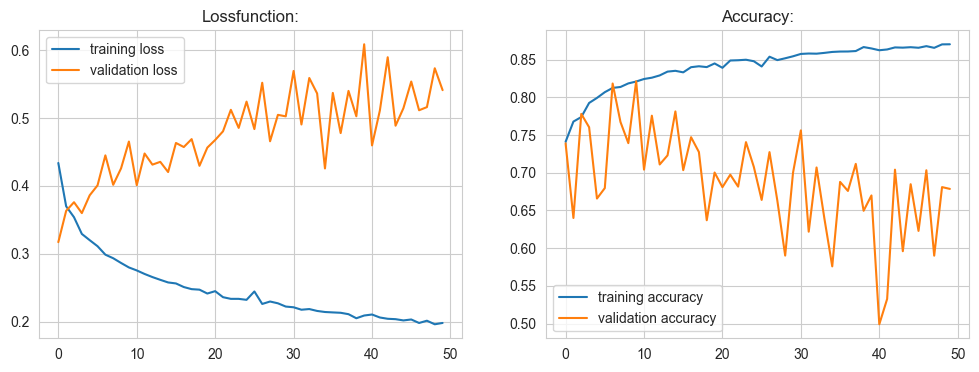

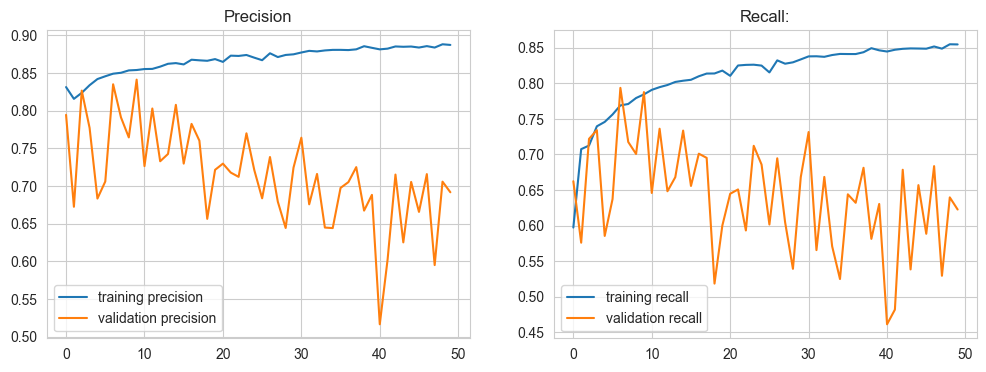

In [70]:
#plot performances
history = modelHistory
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['loss'], label="training loss")
plt.plot(history['val_loss'], label="validation loss")
plt.title('Lossfunction:')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label="training accuracy")
plt.plot(history['val_accuracy'], label="validation accuracy")
plt.title('Accuracy:')
plt.legend()

#plot performances
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['precision'], label="training precision")
plt.plot(history['val_precision'], label="validation precision")
plt.title('Precision')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['recall'], label="training recall")
plt.plot(history['val_recall'], label="validation recall")
plt.title('Recall:')
plt.legend()

# Evaluation

In [72]:
y_pred = model.predict(X_test)

704/704 [==============================] - 4s 5ms/step


In [73]:
predicted_class = np.argmax(y_pred, axis=-1)

In [74]:
test_classes = np.argmax(one_hot_encoded_array_test, axis=-1)

In [75]:
cm = confusion_matrix(test_classes,predicted_class)

In [76]:
classes_name = ['N', 'S', 'V']

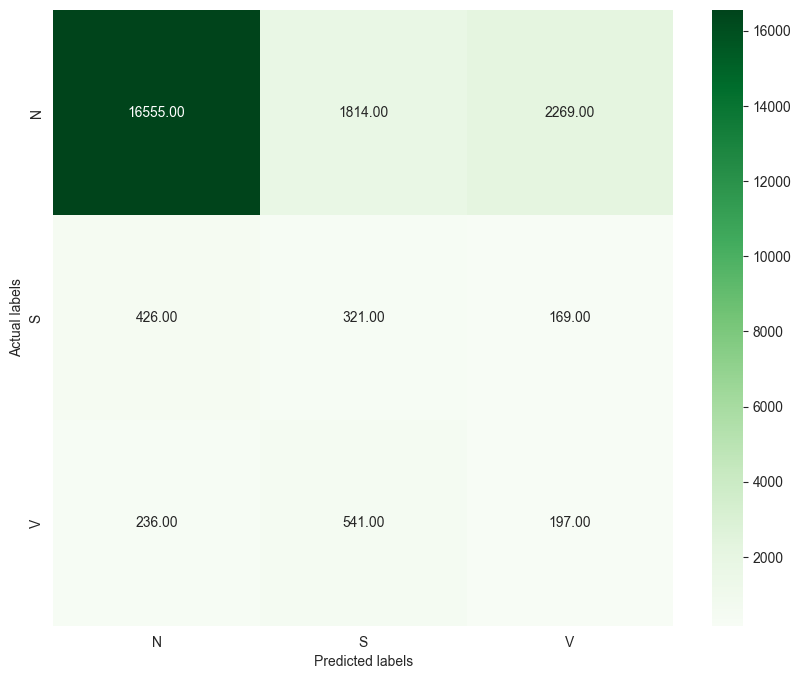

In [77]:
plt.figure(figsize=(10,8))
sns.heatmap(cm, xticklabels=list(classes_name), yticklabels=list(classes_name), cmap="Greens", annot=True, fmt='.2f')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

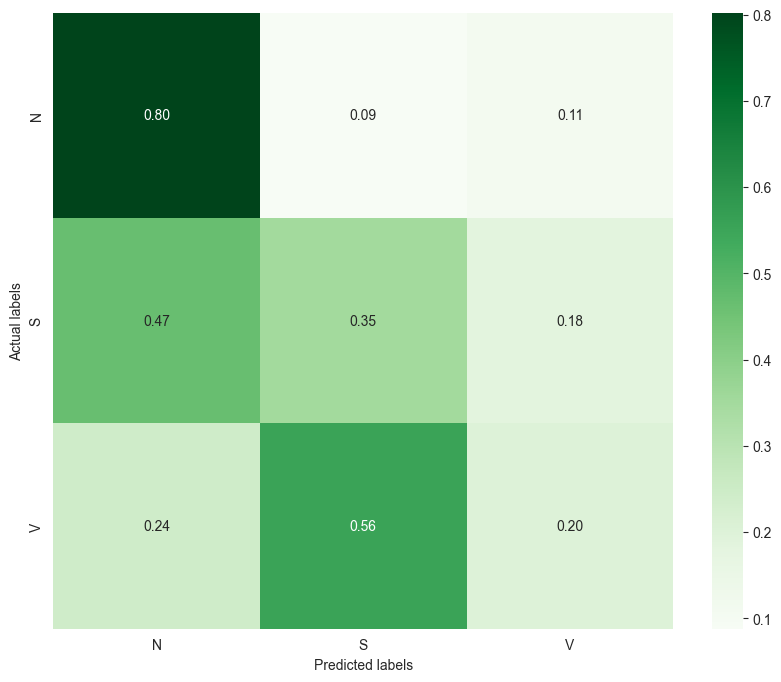

In [78]:
#Normalized cm

cm.sum(axis=1)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,8))
sns.heatmap(cm, xticklabels=list(classes_name), yticklabels=list(classes_name), cmap="Greens", annot=True, fmt='.2f')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()